In [2]:
from datasets import load_dataset

In [3]:
ds = load_dataset("beans")
ds

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

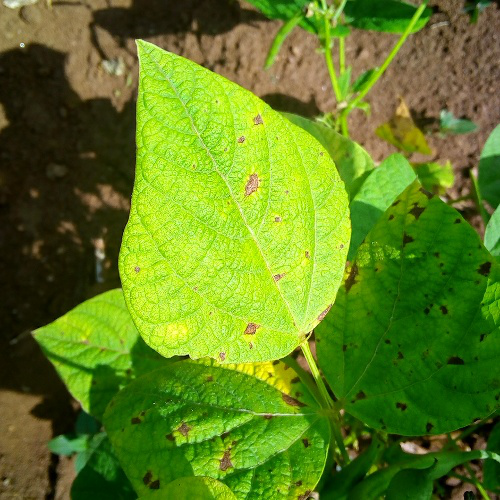

In [6]:
ds["train"][100]["image"]

In [9]:
ds["train"].features["labels"]

ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)

In [42]:
from transformers.utils.dummy_vision_objects import ImageGPTFeatureExtractor
import random
from PIL import ImageDraw, ImageFont, Image
from transformers import (
    ViTFeatureExtractor,
    ViTForImageClassification,
    TrainingArguments,
    Trainer,
)
import torch

import numpy as np
from datasets import load_metric

Filter:   0%|          | 0/1034 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1034 [00:00<?, ? examples/s]

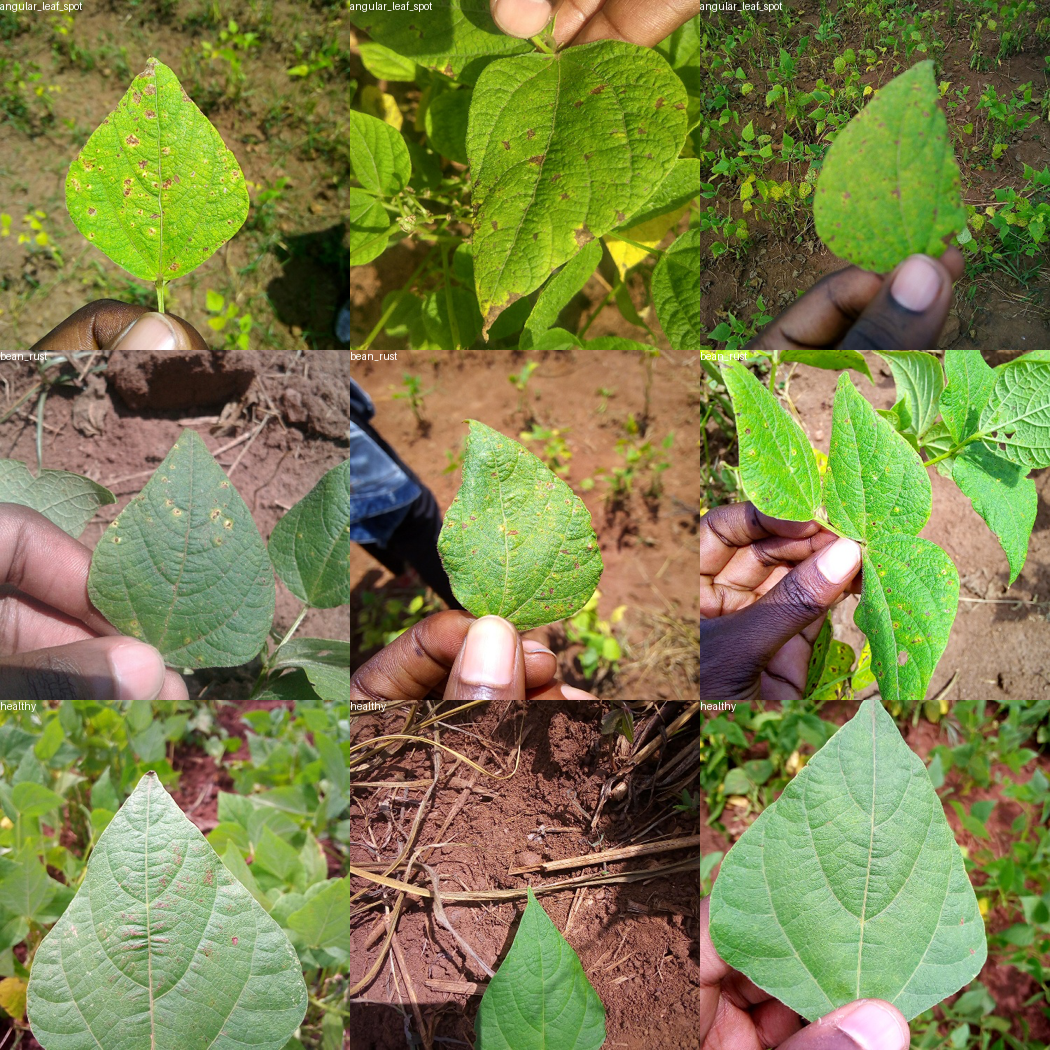

In [14]:
def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):
    w, h = size
    labels = ds["train"].features["labels"].names
    grid = Image.new("RGB", size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    # font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels):

        # 종류별로 데이터를 가져오고, 섞어서 몇 가지 샘플을 보여주도록 합니다
        ds_slice = (
            ds["train"]
            .filter(lambda ex: ex["labels"] == label_id)
            .shuffle(seed)
            .select(range(examples_per_class))
        )

        # 각 행을 따라 시각화합니다
        for i, example in enumerate(ds_slice):
            image = example["image"]
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255))

    return grid


show_examples(ds, seed=random.randint(0, 1337), examples_per_class=3)

In [19]:
model_name_or_path = "google/vit-base-patch16-224-in21k"
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

c:\Users\user\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub\models--google--vit-base-patch16-224-in21k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
loading configuration file preprocessor_config.json from cache at C:\Users\user\.cache\huggingface\hub\model

In [20]:
def process_example(example):
    inputs = feature_extractor(
        example["image"], return_tensor="pt"
    )  # 입력된 데이터를 파이토시 tensor로 변환해서 넣겠다
    inputs["label"] = example["labels"]
    return inputs

In [21]:
process_example(ds["train"][0])

c:\Users\user\anaconda3\Lib\site-packages\transformers\image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTFeatureExtractor.preprocess` and were ignored: 'return_tensor'
  return self.preprocess(images, **kwargs)


{'pixel_values': [array([[[-0.5686275 , -0.5686275 , -0.56078434, ..., -0.02745098,
          0.19215691, -0.25490195],
        [-0.60784316, -0.6       , -0.58431375, ..., -0.03529412,
         -0.01960784, -0.27058822],
        [-0.6313726 , -0.6313726 , -0.6156863 , ..., -0.23921567,
         -0.36470586, -0.23137254],
        ...,
        [-0.5372549 , -0.5529412 , -0.5764706 , ..., -0.0745098 ,
         -0.04313725, -0.09803921],
        [-0.56078434, -0.5764706 , -0.58431375, ...,  0.3176471 ,
          0.16078436,  0.12941182],
        [-0.58431375, -0.5921569 , -0.60784316, ...,  0.27843142,
          0.14509809,  0.20000005]],

       [[-0.70980394, -0.70980394, -0.7490196 , ..., -0.372549  ,
         -0.1607843 , -0.6       ],
        [-0.73333335, -0.73333335, -0.75686276, ..., -0.35686272,
         -0.31764704, -0.56078434],
        [-0.7490196 , -0.7490196 , -0.7647059 , ..., -0.5372549 ,
         -0.6627451 , -0.5372549 ],
        ...,
        [-0.77254903, -0.7882353 , -

In [22]:
def transform(example_batch):
    inputs = feature_extractor([x for x in example_batch["image"]], return_tensors="pt")

    inputs["labels"] = example_batch["labels"]
    return inputs

In [23]:
prepared_ds = ds.with_transform(transform)
prepared_ds

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

In [24]:
prepared_ds["train"].features["image"]

Image(mode=None, decode=True, id=None)

In [25]:
prepared_ds["train"][100:105]

{'pixel_values': tensor([[[[ 0.1451,  0.2392,  0.4588,  ..., -0.7020, -0.7725, -0.8667],
          [ 0.1843,  0.2706,  0.5373,  ..., -0.3333, -0.5686, -0.8275],
          [ 0.1922,  0.1216,  0.2549,  ..., -0.0902, -0.3961, -0.7569],
          ...,
          [-0.2784, -0.1294, -0.0980,  ..., -0.3882, -0.6627, -0.7255],
          [-0.1765, -0.1059, -0.1529,  ..., -0.3490, -0.6471, -0.6392],
          [-0.1765, -0.1608, -0.2000,  ..., -0.3804, -0.6941, -0.7020]],

         [[ 0.0353,  0.1686,  0.4588,  ..., -0.7647, -0.8275, -0.8980],
          [ 0.0510,  0.1843,  0.5137,  ..., -0.4667, -0.6549, -0.8667],
          [ 0.0510,  0.0196,  0.2000,  ..., -0.2549, -0.5059, -0.8275],
          ...,
          [-0.3804, -0.2314, -0.2000,  ..., -0.4118, -0.5765, -0.6157],
          [-0.2863, -0.2235, -0.2627,  ..., -0.4824, -0.7020, -0.6706],
          [-0.2941, -0.2863, -0.3176,  ..., -0.4980, -0.7647, -0.7569]],

         [[-0.3725, -0.1294,  0.2627,  ..., -0.8667, -0.9294, -0.9922],
          [-0

In [27]:
def collate_fn(batch):
    return {
        "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
        "labels": torch.tensor([x["labels"] for x in batch]),
    }

In [30]:
metric = load_metric("accuracy", trust_remote_code=True)


def compute_metrics(p):
    return metric.compute(
        predictions=np.argmax(p.predictions, axis=1), references=p.label_ids
    )

In [33]:
labels = ds["train"].features["labels"].names

In [39]:
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
)

loading configuration file config.json from cache at C:\Users\user\.cache\huggingface\hub\models--google--vit-base-patch16-224-in21k\snapshots\b4569560a39a0f1af58e3ddaf17facf20ab919b0\config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "angular_leaf_spot",
    "1": "bean_rust",
    "2": "healthy"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "angular_leaf_spot": "0",
    "bean_rust": "1",
    "healthy": "2"
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.44.2"
}

loading weights file model.safetensors from cache at C:\Users\user\.cache\h

In [41]:
training_args = TrainingArguments(
    output_dir="./",
    per_device_train_batch_size=16,
    eval_strategy="steps",
    num_train_epochs=2,
    fp16=True,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    learning_rate=0.01,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to="tensorboard",
    load_best_model_at_end=True,
)

PyTorch: setting up devices


In [44]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)

Using auto half precision backend


In [45]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** Running training *****
  Num examples = 1,034
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 130
  Number of trainable parameters = 85,800,963


  0%|          | 0/130 [00:00<?, ?it/s]

{'loss': 1.2161, 'grad_norm': 1.3071976900100708, 'learning_rate': 0.009230769230769232, 'epoch': 0.15}
{'loss': 1.1701, 'grad_norm': 0.2272910475730896, 'learning_rate': 0.008461538461538461, 'epoch': 0.31}
{'loss': 1.1418, 'grad_norm': 0.42757153511047363, 'learning_rate': 0.007692307692307693, 'epoch': 0.46}
{'loss': 1.1215, 'grad_norm': 0.565277636051178, 'learning_rate': 0.006923076923076923, 'epoch': 0.62}
{'loss': 1.1215, 'grad_norm': 0.17698563635349274, 'learning_rate': 0.006153846153846155, 'epoch': 0.77}
{'loss': 1.0955, 'grad_norm': 0.2495405673980713, 'learning_rate': 0.005384615384615384, 'epoch': 0.92}
{'loss': 1.0811, 'grad_norm': 0.5590391755104065, 'learning_rate': 0.004615384615384616, 'epoch': 1.08}
{'loss': 1.0861, 'grad_norm': 0.22302749752998352, 'learning_rate': 0.0038461538461538464, 'epoch': 1.23}
{'loss': 0.9694, 'grad_norm': 0.3042948246002197, 'learning_rate': 0.0030769230769230774, 'epoch': 1.38}



***** Running Evaluation *****
  Num examples = 133
  Batch size = 8


{'loss': 1.01, 'grad_norm': 0.5521892309188843, 'learning_rate': 0.002307692307692308, 'epoch': 1.54}


  0%|          | 0/17 [00:00<?, ?it/s]

Saving model checkpoint to ./checkpoint-100
Configuration saved in ./checkpoint-100\config.json
Model weights saved in ./checkpoint-100\model.safetensors
Image processor saved in ./checkpoint-100\preprocessor_config.json


{'eval_loss': 0.9805814027786255, 'eval_accuracy': 0.49624060150375937, 'eval_runtime': 10.0936, 'eval_samples_per_second': 13.177, 'eval_steps_per_second': 1.684, 'epoch': 1.54}
{'loss': 0.9875, 'grad_norm': 0.26360654830932617, 'learning_rate': 0.0015384615384615387, 'epoch': 1.69}
{'loss': 1.0275, 'grad_norm': 21.839263916015625, 'learning_rate': 0.0007692307692307693, 'epoch': 1.85}


Saving model checkpoint to ./checkpoint-130
Configuration saved in ./checkpoint-130\config.json


{'loss': 1.0116, 'grad_norm': 0.3938537538051605, 'learning_rate': 0.0, 'epoch': 2.0}


Model weights saved in ./checkpoint-130\model.safetensors
Image processor saved in ./checkpoint-130\preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./checkpoint-100 (score: 0.9805814027786255).
Saving model checkpoint to ./
Configuration saved in ./config.json


{'train_runtime': 531.5032, 'train_samples_per_second': 3.891, 'train_steps_per_second': 0.245, 'train_loss': 1.0799959549537073, 'epoch': 2.0}


Model weights saved in ./model.safetensors
Image processor saved in ./preprocessor_config.json


***** train metrics *****
  epoch                    =         2.0
  total_flos               = 149248978GF
  train_loss               =        1.08
  train_runtime            =  0:08:51.50
  train_samples_per_second =       3.891
  train_steps_per_second   =       0.245
